# 🏀 March Machine Learning Mania 2025 — Feature Engineering & Model Building

This notebook continues from the EDA phase, applying domain insights to construct meaningful features and predictive models for the [Kaggle March Madness 2025](https://www.kaggle.com/competitions/march-machine-learning-mania-2025/overview) competition.

🎯 **Objective**  
Predict NCAA tournament game outcomes using machine learning. Submissions are evaluated with the **Brier score**, which measures the accuracy of predicted probabilities.

📦 **Data Overview**  
We utilize a wide range of historical features:
- Team performance stats (season, tournament, margin of victory, etc.)
- Coaching records and clutch win rates
- Pre-tournament Elo and system-based rankings
- Game-level box score statistics

Each dataset is joined and engineered to build a robust "super dataset" for modeling.



## SET UP

In [ ]:
# Essential Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm #crating progress bar in loops
import os
import ipywidgets as widgets #for creating interactive widgets(slider, dropdown etc)
from IPython.display import display
import warnings



In [ ]:
# Settings
sns.set_style("whitegrid")
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
warnings.filterwarnings("ignore")

## DATASET

In [ ]:
base_path = r"C:\Users\ADMIN\Desktop\Kaggle\March_Machine_Learning_Mania_2025"
# List files in the subdirectory
if os.path.exists(base_path):
    print(f"Listing files in {base_path}:")
    for dirpath, subdir, filenames in os.walk(base_path):
        for file in filenames:
            print(f"File: {file}")
else:
    print(f"Directory not found: {base_path}")

In [ ]:
# Load the data
## Section 1 - Basics
###### Mens 
men_teams = pd.read_csv(f"{base_path}\input\Section_1_Basics\MTeams.csv")
mncaa_seed = pd.read_csv(f"{base_path}\input\Section_1_Basics\MNCAATourneySeeds.csv")
mreg_compact = pd.read_csv(f"{base_path}\input\Section_1_Basics\MRegularSeasonCompactResults.csv")
mncaa_compact = pd.read_csv(f"{base_path}\input\Section_1_Basics\MNCAATourneyCompactResults.csv")
men_seasons = pd.read_csv(f"{base_path}\input\Section_1_Basics\MSeasons.csv")
##### Womens 
women_teams = pd.read_csv(f"{base_path}\input\Section_1_Basics\WTeams.csv")
women_seasons = pd.read_csv(f"{base_path}\input\Section_1_Basics\WSeasons.csv")
wncaa_seed = pd.read_csv(f"{base_path}\input\Section_1_Basics\WNCAATourneySeeds.csv")
wreg_compact = pd.read_csv(f"{base_path}\input\Section_1_Basics\WRegularSeasonCompactResults.csv")
wncaa_compact = pd.read_csv(f"{base_path}\input\Section_1_Basics\WNCAATourneyCompactResults.csv")

## Section 2 - Boxscore
mncaa_detailed = pd.read_csv(f"{base_path}\input\Section_2_Boxscore\MNCAATourneyDetailedResults.csv")
mreg_detailed = pd.read_csv(f"{base_path}\input\Section_2_Boxscore\MRegularSeasonDetailedResults.csv")
wreg_detailed = pd.read_csv(f"{base_path}\input\Section_2_Boxscore\WRegularSeasonDetailedResults.csv")
wncaa_detailed = pd.read_csv(f"{base_path}\input\Section_2_Boxscore\WNCAATourneyDetailedResults.csv")

## Section 3 - Geography
# mens_games_cities = pd.read_csv(f"{base_path}\input\Section_3_Geography\MGameCities.csv")
# womens_games_cities = pd.read_csv(f"{base_path}\input\Section_3_Geography\WGameCities.csv")
# cities = pd.read_csv(f"{base_path}\input\Section_3_Geography\Cities.csv")

## Section 4 - Rankings
rankings = pd.read_csv(f"{base_path}\input\Section_4_Ranking\MMasseyOrdinals.csv")

### Section 5 - Supplements 
#regular_season_conference = pd.read_csv(f"{base_path}\input\Section_5_Supplements\Conferences.csv")
men_coaches = pd.read_csv(f"{base_path}\input\Section_5_Supplements\MTeamCoaches.csv")
men_team_conferences = pd.read_csv(f"{base_path}\input\Section_5_Supplements\MTeamConferences.csv")
#mncaa_slots = pd.read_csv(f"{base_path}\input\Section_5_Supplements\MNCAATourneySlots.csv")
#mncaa_seed_round_slots = pd.read_csv(f"{base_path}\input\Section_5_Supplements\MNCAATourneySeedRoundSlots.csv")
#md2_compact = pd.read_csv(f"{base_path}\input\Section_5_Supplements\MSecondaryTourneyCompactResults.csv")
#md2_team = pd.read_csv(f"{base_path}\input\Section_5_Supplements\MSecondaryTourneyTeams.csv")
#mteam_spell = pd.read_csv(f"{base_path}\input\Section_5_Supplements\MTeamSpellings.csv")
#women_team_conferences = pd.read_csv(f"{base_path}\input\Section_5_Supplements\WTeamConferences.csv")
#wncaa_slots = pd.raed_csv(f"{base_path}\input\Section_5_Supplements\WNCAATourneySlots.csv")
#wncaa_game = pd.read_csv(f"{base_path}\input\Section_5_Supplements\WConferenceTourneyGames.csv")
#wd2_compact = pd.read_csv(f"{base_path}\input\Section_5_Supplements\WSecondaryTourneyCompactResults.csv")
#wd2_team = pd.read_csv(f"{base_path}\input\Section_5_Supplements\WSecondaryTourneyTeams.csv")

### Submission files 

sample_submission_1 =   pd.read_csv(f"{base_path}\input\SampleSubmissionStage1.csv")
sample_submission_2 = pd.read_csv(f"{base_path}\input\SampleSubmissionStage2.csv")

In [4]:
submission_3 = pd.read_csv(r"C:\Users\Admin\Desktop\Kaggle\March_Machine_Learning_Mania_2025\input\NCAA_from_1985.csv")

## Coach

In [5]:
def process_regular_season(mreg_compact, men_coaches):
    """
    Process regular season data (mreg_compact) to calculate:
    - Cumulative total wins per coach (computed from WTeamID)
    - Cumulative total games played per coach (Wins + Losses from mreg_compact)
    - Cumulative clutch games played (games with margin <= 5, for both wins & losses)
    - Keeps TeamID in the final output
    - Avoids modifying the original datasets
    """

    # ✅ Create copies to ensure original data is not modified
    men_coaches_copy = men_coaches.copy()
    mreg_copy = mreg_compact.copy()

    # ✅ Merge coaches with winning teams
    reg_season = mreg_copy.merge(
        men_coaches_copy[['Season', 'TeamID', 'CoachName']], 
        left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID'], how='left'
    )

    # ✅ Merge coaches with losing teams
    reg_season = reg_season.merge(
        men_coaches_copy[['Season', 'TeamID', 'CoachName']], 
        left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID'], 
        how='left', suffixes=('', '_L')
    )

    # ✅ Compute Total Wins per Coach
    total_wins = reg_season.groupby(['Season', 'CoachName', 'WTeamID']).size().reset_index(name='Coach_Total_Regular_Wins')

    # ✅ Compute Total Losses per Coach
    total_losses = reg_season.groupby(['Season', 'CoachName_L', 'LTeamID']).size().reset_index(name='Coach_Total_Regular_Losses')
    total_losses.rename(columns={'CoachName_L': 'CoachName'}, inplace=True)  

    # ✅ Compute Total Games Played (Wins + Losses)
    total_games = total_wins.merge(total_losses, 
                                   left_on=['Season', 'CoachName', 'WTeamID'],
                                   right_on=['Season', 'CoachName', 'LTeamID'], 
                                   how='outer').fillna(0)

    total_games['Coach_Total_Regular_Games'] = total_games['Coach_Total_Regular_Wins'] + total_games['Coach_Total_Regular_Losses']

    # ✅ Clutch Games (Both Wins & Losses)
    clutch_games = mreg_copy[(mreg_copy['WScore'] - mreg_copy['LScore']) <= 5]

    # ✅ Compute Clutch Wins per Coach
    clutch_wins = clutch_games.merge(men_coaches_copy[['Season', 'TeamID', 'CoachName']], 
                                     left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID'], how='left')
    clutch_wins = clutch_wins.groupby(['Season', 'CoachName', 'WTeamID']).size().reset_index(name='Coach_Clutch_Wins')

    # ✅ Compute Clutch Losses per Coach
    clutch_losses = clutch_games.merge(men_coaches_copy[['Season', 'TeamID', 'CoachName']], 
                                       left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID'], how='left')
    clutch_losses = clutch_losses.groupby(['Season', 'CoachName', 'LTeamID']).size().reset_index(name='Coach_Clutch_Losses')

    # ✅ Merge Clutch Wins & Losses
    clutch_stats = clutch_wins.merge(clutch_losses, on=['Season', 'CoachName'], how='outer').fillna(0)

    # ✅ Fix: Assign TeamID from Total Wins/Losses (Avoids 0)
    clutch_stats['TeamID'] = clutch_stats['WTeamID'].combine_first(clutch_stats['LTeamID']).astype(int)
    clutch_stats.drop(columns=['WTeamID', 'LTeamID'], inplace=True, errors='ignore')

    # ✅ Fix: Compute `Coach_Total_Clutch_Games`
    clutch_stats['Coach_Total_Clutch_Games'] = clutch_stats['Coach_Clutch_Wins'] + clutch_stats['Coach_Clutch_Losses']

    # ✅ Merge Clutch Stats with Total Wins/Losses
    coach_stats = total_games.merge(clutch_stats, on=['Season', 'CoachName'], how='left').fillna(0)

    # ✅ Ensure numeric types
    numeric_cols = ['Coach_Total_Regular_Wins', 'Coach_Total_Regular_Losses', 'Coach_Total_Regular_Games',
                    'Coach_Clutch_Wins', 'Coach_Clutch_Losses', 'Coach_Total_Clutch_Games']
    coach_stats[numeric_cols] = coach_stats[numeric_cols].astype(int)

    # ✅ Compute Cumulative Sums
    coach_stats = coach_stats.sort_values(by=['CoachName', 'Season'], ascending=True)
    coach_stats['Cumulative_Coach_Total_Wins'] = coach_stats.groupby('CoachName')['Coach_Total_Regular_Wins'].cumsum()
    coach_stats['Cumulative_Coach_Total_Games'] = coach_stats.groupby('CoachName')['Coach_Total_Regular_Games'].cumsum()
    coach_stats['Cumulative_Coach_Clutch_Wins'] = coach_stats.groupby('CoachName')['Coach_Clutch_Wins'].cumsum()
    coach_stats['Cumulative_Coach_Clutch_Losses'] = coach_stats.groupby('CoachName')['Coach_Clutch_Losses'].cumsum()
    coach_stats['Cumulative_Coach_Total_Clutch_Games'] = coach_stats.groupby('CoachName')['Coach_Total_Clutch_Games'].cumsum()

    # ✅ Ensure `TeamID` is retained and drop extra columns
    coach_stats = coach_stats[['Season', 'TeamID', 'CoachName', 
                               'Cumulative_Coach_Total_Wins', 'Cumulative_Coach_Total_Games', 
                               'Cumulative_Coach_Clutch_Wins', 'Cumulative_Coach_Clutch_Losses', 
                               'Cumulative_Coach_Total_Clutch_Games']]

    # ✅ Drop rows where `TeamID` is missing or 0
    coach_stats = coach_stats[coach_stats['TeamID'] != 0]

    return coach_stats

# ✅ Run the Function
b_reg = process_regular_season(mreg_compact, men_coaches)

# ✅ Check if `TeamID = 0` Exists
# Should return an empty DataFrame


In [6]:
def process_postseason(mncaa_compact, men_coaches):
    """
    Process postseason data (mncaa_compact) to calculate:
    - Cumulative total postseason wins per coach
    - Total postseason games played (Round Exit)
    - Cumulative postseason clutch wins (games won by ≤5 points)
    - Avoids modifying the original datasets
    """

    # ✅ Step 1: Prepare Coaches Data
    men_coaches = men_coaches.sort_values(by=['CoachName', 'TeamID', 'Season'])

    # 🔹 Compute cumulative experience per coach (number of seasons coached)
    men_coaches['exp_team'] = men_coaches.groupby(['CoachName', 'TeamID']).cumcount() + 1
    men_coaches['exp_ncaa'] = men_coaches.groupby(['CoachName']).cumcount() + 1

    # 🔹 Identify Coach Changes (1 if new coach in that season)
    men_coaches['CoachChange'] = (men_coaches['FirstDayNum'] != 0).astype(int)

    # 🔹 Keep only coaches who finished the season (LastDayNum == 154)
    men_coaches = men_coaches[men_coaches['LastDayNum'] == 154].drop(columns=['LastDayNum', 'FirstDayNum'])

    # ✅ Step 2: Merge Coaches with Postseason Data
    postseason = mncaa_compact.merge(men_coaches, left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID'], how='left')
    postseason = postseason.merge(men_coaches, left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID'], how='left', suffixes=('', '_L'))

    # ✅ Step 3: Compute Wins Normally (Reverting to Your Original Logic)
    total_wins = postseason.groupby(['Season', 'WTeamID', 'CoachName']).size().reset_index(name='Total_OffSeason_Wins')

    # ✅ Step 4: Assign `Total_OffSeason_Lost = 1` for All Losing Teams
    lost = postseason[['Season', 'LTeamID', 'CoachName_L']].drop_duplicates()
    lost = lost.rename(columns={'LTeamID': 'TeamID', 'CoachName_L': 'CoachName'})
    lost['Total_OffSeason_Lost'] = 1  # Every losing team gets exactly 1 loss

    # ✅ Step 5: Merge Wins & Losses on TeamID (Your Original Merge Logic)
    total_win_lost = total_wins.rename(columns={'WTeamID': 'TeamID'}).merge(
        lost, on=['Season', 'TeamID', 'CoachName'], how='outer'
    )

    # 🔹 Fill NaN for Teams That Never Lost or Never Won
    total_win_lost['Total_OffSeason_Wins'] = total_win_lost['Total_OffSeason_Wins'].fillna(0)
    total_win_lost['Total_OffSeason_Lost'] = total_win_lost['Total_OffSeason_Lost'].fillna(0)

    # 🔹 Compute Round Exit
    total_win_lost['OffSeason_Round_Exit'] = total_win_lost['Total_OffSeason_Wins'] + total_win_lost['Total_OffSeason_Lost']

    # ✅ Step 6: Compute Postseason Clutch Wins (Wins by ≤5 Points)
    clutch_wins = postseason[(postseason['WScore'] - postseason['LScore']) <= 5]
    clutch_wins = clutch_wins.groupby(['Season', 'WTeamID', 'CoachName']).size().reset_index(name='Total_OffSeason_Clutch_Wins')

    # 🔹 Merge Clutch Wins on WTeamID BEFORE dropping it
    total_win_lost = total_win_lost.merge(clutch_wins.rename(columns={'WTeamID': 'TeamID'}), 
                                          on=['Season', 'TeamID', 'CoachName'], how='left').fillna(0)

    # ✅ Step 7: Merge with Coaches Data
    b = men_coaches.merge(total_win_lost, on=['Season', 'TeamID', 'CoachName'], how='left')

    # 🔹 Fill missing values
    b[['Total_OffSeason_Wins', 'Total_OffSeason_Lost', 'OffSeason_Round_Exit', 'Total_OffSeason_Clutch_Wins']] = b[
        ['Total_OffSeason_Wins', 'Total_OffSeason_Lost', 'OffSeason_Round_Exit', 'Total_OffSeason_Clutch_Wins']
    ].fillna(0)

    # ✅ Step 8: Compute Cumulative Stats (Your Original Cumsum Logic)
    b = b.sort_values(by=['CoachName', 'Season'])
    b['OffSeason_Cumulative_Coach_Wins'] = b.groupby('CoachName')['Total_OffSeason_Wins'].cumsum().shift(1).fillna(0)
    b['OffSeason_Cumulative_Coach_Clutch_Wins'] = b.groupby('CoachName')['Total_OffSeason_Clutch_Wins'].cumsum().shift(1).fillna(0)

    return b

# ✅ Run the function again
b = process_postseason(mncaa_compact, men_coaches)



In [7]:
coaches_stat = b_reg.merge(b, on=['Season', 'TeamID', 'CoachName'], how='outer')
coaches_stat = coaches_stat.fillna(0)
coaches_stat['TeamID'] = coaches_stat['TeamID'].astype(int)


## Extract Seed

In [8]:
def extract_seed(df):
    seed = df
    seed['Region'] = df['Seed'].apply(lambda x:x[0])
    seed['Seeding'] = df['Seed'].apply(lambda x:x[1:]).str.extract('(\d+)').astype(int)
    return seed.drop('Seed',axis =1)
male_season_seed = extract_seed(mncaa_seed)
female_season_seed = extract_seed(wncaa_seed)
mncaa_seed.head()

,Season,Seed,TeamID,Region,Seeding
0,1985,W01,1207,W,1
1,1985,W02,1210,W,2
2,1985,W03,1228,W,3
3,1985,W04,1260,W,4
4,1985,W05,1374,W,5


## Ranking

In [9]:

last_day_ranking = rankings.groupby(['Season','SystemName','TeamID'])['RankingDayNum'].max().reset_index() ## Extract the lastest ranking of the season of the team
last_day_ranking = pd.merge(last_day_ranking,rankings,how = 'left',on = ['Season','SystemName','TeamID','RankingDayNum'])
last_day_ranking.drop('RankingDayNum',axis = 1, inplace = True)
lastest_ranking = last_day_ranking.pivot(index = ["Season","TeamID"],columns = "SystemName",values = "OrdinalRank").reset_index()
male_ranking = lastest_ranking.apply(lambda row: row.fillna(np.ceil(row.mean()) ),axis=1 ) # Replace all Na value with mean of ranking across all system
male_ranking.isna().sum()
male_ranking.columns = ['_'.join(col) if isinstance(col, tuple) else col for col in male_ranking.columns]
male_ranking_old = male_ranking[male_ranking['Season'] < 2021].groupby('TeamID').agg('mean').reset_index()
male_ranking_old.drop('Season',axis = 1,inplace = True)
male_ranking_old = male_ranking_old.set_index('TeamID').mean(axis=1).reset_index()
male_ranking_new = male_ranking.merge(male_ranking_old,how = 'left',on = 'TeamID')

## Elo

In [10]:
def calculate_elo(games, initial_elo=1500, K=20, home_advantage=15, mov_cap = 1.5):
    """
    Compute evolving ELO ratings for teams from game-level data, 
    ensuring ELO resets at the start of each season.
    
    Parameters:
      - games (DataFrame): Regular season results (must include Season, WTeamID, LTeamID, WScore, LScore, WLoc)
      - initial_elo (int): Starting ELO rating for all teams (default 1500).
      - K (int): The K-factor for rating updates.
      - home_advantage (int): Points added to the home team's ELO.
      
    Returns:
      - elo_df (DataFrame): Updated ELO ratings for each game.
    """
    games = games.sort_values(by=['Season', 'DayNum'])
    elo_ratings = {}  # Dictionary to store ELO ratings per team
    elo_updates = []  # Store ELO updates per game
    
    for season, season_games in games.groupby('Season'):
        # 🔥 **Reset ELO ratings at the start of each season**
        elo_ratings = {team: initial_elo for team in set(season_games['WTeamID']).union(set(season_games['LTeamID']))}
        for _, row in season_games.iterrows():
            team1 = row['WTeamID']
            team2 = row['LTeamID']
            score1 = row['WScore']
            score2 = row['LScore']

            # Get current ELO ratings or initialize to 1500
            R1 = elo_ratings.get(team1, initial_elo)
            R2 = elo_ratings.get(team2, initial_elo)

            # Apply home advantage
            if row['WLoc'] == 'H':
                R1 += home_advantage
            elif row['WLoc'] == 'A':
                R2 += home_advantage

            # Compute expected scores
            expected1 = 1 / (1 + 10 ** ((R2 - R1) / 400))
            expected2 = 1 - expected1  # Since sum of probabilities must be 1
           
            # **Fixed MOV Multiplier to Cap Growth**
            margin = abs(score1 - score2)
            mov_multiplier = np.log(margin + 1) * (2.2 / (abs(R1 - R2) * 0.001 + 2.2))
            mov_multiplier = min(mov_multiplier, mov_cap)  # 🔥 Cap the MOV multiplier

            # Update ELO ratings
            new_R1 = R1 + K * mov_multiplier * (1 - expected1) 
            new_R2 = R2 + K * mov_multiplier * (0 - expected2) 
           
            # Save updated ELOs
            elo_ratings[team1] = new_R1
            elo_ratings[team2] = new_R2

            # Store game results
            elo_updates.append({
                'Season': row['Season'],
                'DayNum': row['DayNum'],
                'Team1': team1,
                'Team2': team2,
                'Team1Elo': new_R1,
                'Team2Elo': new_R2
            })

    return pd.DataFrame(elo_updates)


In [11]:


def compute_pretournament_elo(regular_season_data, tournament_data):
    """
    Compute and merge the latest pre-tournament ELO ratings for teams before the NCAA tournament.

    Parameters:
      - regular_season_data (DataFrame): Regular season results for computing ELO.
      - tournament_data (DataFrame): NCAA tournament matchups where ELO will be merged.

    Returns:
      - tournament_data (DataFrame): Tournament data with `PreTournamentElo_WTeam` and `PreTournamentElo_LTeam` merged.
    """
    # Compute ELO for each season separately
    elo_list = []
    for season in sorted(regular_season_data['Season'].unique()):  # Ensure correct ordering
        season_data = regular_season_data[regular_season_data['Season'] == season]
        season_elo = calculate_elo(season_data, initial_elo=1500, K=20, home_advantage=15,mov_cap=2)  # Reduced home_advantage
        elo_list.append(season_elo)
    
    # Combine ELO history into a single DataFrame
    elo_df = pd.concat(elo_list, ignore_index=True)

    # Ensure data types match for merging
    tournament_data = tournament_data.copy()
    tournament_data[['Season', 'WTeamID', 'LTeamID']] = tournament_data[['Season', 'WTeamID', 'LTeamID']].astype(int)

    elo_df[['Season', 'Team1']] = elo_df[['Season', 'Team1']].astype(int)

    # Get the latest ELO before NCAA tournament (last regular season game for each team)
    final_reg_season_elo = elo_df.loc[elo_df.groupby(['Season', 'Team1'])['DayNum'].idxmax()].copy()

    # Merge latest ELO before NCAA for winning team (WTeamID)
    tournament_data = tournament_data.merge(
        final_reg_season_elo[['Season', 'Team1', 'Team1Elo']], 
        left_on=['Season', 'WTeamID'], 
        right_on=['Season', 'Team1'], 
        how='left'
    ).rename(columns={'Team1Elo': 'PreTournamentElo_WTeam'})

    # Merge latest ELO before NCAA for losing team (LTeamID)
    tournament_data = tournament_data.merge(
        final_reg_season_elo[['Season', 'Team1', 'Team1Elo']], 
        left_on=['Season', 'LTeamID'], 
        right_on=['Season', 'Team1'], 
        how='left'
    ).rename(columns={'Team1Elo': 'PreTournamentElo_LTeam'})

    # Drop redundant columns
    tournament_data.drop(columns=['Team1_x', 'Team1_y'], errors='ignore', inplace=True)

    # Fill missing ELO values (teams with no games get 1500)
    tournament_data[['PreTournamentElo_WTeam', 'PreTournamentElo_LTeam']] = tournament_data[
        ['PreTournamentElo_WTeam', 'PreTournamentElo_LTeam']
    ].fillna(1500)

    return tournament_data

# ✅ Run the function
tournament_men_data = compute_pretournament_elo(mreg_compact, mncaa_compact)
tournament_women_data = compute_pretournament_elo(wreg_compact, wncaa_compact)


In [12]:
tournament_men_data.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,PreTournamentElo_WTeam,PreTournamentElo_LTeam
0,1985,136,1116,63,1234,54,N,0,1821.381234,1893.950688
1,1985,136,1120,59,1345,58,N,0,1803.037887,1852.725249
2,1985,136,1207,68,1250,43,N,0,2015.563272,1580.939263
3,1985,136,1229,58,1425,55,N,0,1865.327777,1805.277310
4,1985,136,1242,49,1325,38,N,0,1910.450287,1822.909726


In [13]:

def calculate_srs(games):
    """
    Calculate the Simple Rating System (SRS) for each team in each season.
    
    Parameters:
    - games (DataFrame): Regular season data with 'Season', 'WTeamID', 'LTeamID', 'WScore', and 'LScore'.
    
    Returns:
    - srs_df (DataFrame): Team-level SRS ratings.
    """
    # Calculate raw margin of victory
    games['MOV_W'] = games['WScore'] - games['LScore']
    games['MOV_L'] = games['LScore'] - games['WScore']

    # Get team average MOV (for both winning and losing teams)
    mov_winners = games.groupby(['Season', 'WTeamID'])['MOV_W'].mean().reset_index()
    mov_losers = games.groupby(['Season', 'LTeamID'])['MOV_L'].mean().reset_index()

    # Rename columns for clarity
    mov_winners.rename(columns={'WTeamID': 'TeamID', 'MOV_W': 'MOV'}, inplace=True)
    mov_losers.rename(columns={'LTeamID': 'TeamID', 'MOV_L': 'MOV'}, inplace=True)

    # Combine win and loss MOVs and compute final SRS
    srs_df = pd.concat([mov_winners, mov_losers])
    srs_df = srs_df.groupby(['Season', 'TeamID'])['MOV'].mean().reset_index()
    srs_df.rename(columns={'MOV': 'SRS'}, inplace=True)  # Rename to SRS for clarity

    return srs_df

# Compute SRS for both Men's and Women's games
srs_men = calculate_srs(mreg_compact)
srs_women = calculate_srs(wreg_compact)



In [14]:
def process_team_data(team):

    results  =  mreg_compact if team['TeamID'].max() < 3000 else wreg_compact
    results['p_day'] = (results['DayNum'] / results['DayNum'].max()) + 0.5
    wppg = results.groupby(['Season', 'WTeamID']).agg({'WScore': 'mean'}).reset_index()
    lppg = results.groupby(['Season', 'LTeamID']).agg({'LScore': 'mean'}).reset_index()
    owppg =results.groupby(['Season', 'WTeamID']).agg({'LScore': 'mean'}).reset_index()
    olppg = results.groupby(['Season', 'LTeamID']).agg({'WScore': 'mean'}).reset_index()
    win = results.groupby(['Season', 'WTeamID']).size().reset_index(name='Win')
    loss = results.groupby(['Season', 'LTeamID']).size().reset_index(name='Loss')
    wdifferential = wppg['WScore'] - owppg['LScore']
    ldifferential = (lppg['LScore'] - olppg['WScore']) 
    pdifferential = wdifferential - ldifferential
    wwin = results.groupby(['Season', 'WTeamID']).agg({'p_day': 'sum'}).reset_index()
    wloss = results.groupby(['Season', 'LTeamID']).agg({'p_day': 'sum'}).reset_index()

    team = pd.DataFrame({'TeamID': results['WTeamID'].unique()})
    team = team.merge(win, how='left', left_on=['TeamID'], right_on=['WTeamID']).drop(columns=['WTeamID'])
    team.rename(columns={0: 'Win'}, inplace=True)
    team = team.merge(loss, how='left', left_on=['TeamID', 'Season'], right_on=['LTeamID', 'Season']).drop(columns=['LTeamID'])
    team = team.merge(wwin, how='left', left_on=['TeamID', 'Season'], right_on=['WTeamID', 'Season']).drop(columns=['WTeamID'])
    team.rename(columns={'p_day': 'Weighted Wins'}, inplace=True)
    team = team.merge(wloss, how='left', left_on=['TeamID', 'Season'], right_on=['LTeamID', 'Season']).drop(columns=['LTeamID'])
    team.rename(columns={'p_day': 'Weighted Losses'}, inplace=True)

    # Add differentials
    team['Win Point Differential'] = wdifferential
    team['Loss Point Differential'] = ldifferential
    team['Point Differential'] = pdifferential

    # Add points data
    team['Points in Wins'] = wppg['WScore']
    team['Points in Losses'] = lppg['LScore']
    team['Opponent Points in Wins'] = owppg['LScore']
    team['Opponent Points in Losses'] = olppg['WScore']

    return team


In [15]:
# Example usage
processed_female_teams = process_team_data(women_teams)
processed_men_teams = process_team_data(men_teams)


In [16]:

process_srs_men = processed_men_teams.merge(srs_men, how='left', on=['Season', 'TeamID'])

process_srs_women = processed_female_teams.merge(srs_women, how='left', on=['Season', 'TeamID'])


In [17]:
process_srs_men.head()

,TeamID,Season,Win,Loss,Weighted Wins,Weighted Losses,Win Point Differential,Loss Point Differential,Point Differential,Points in Wins,Points in Losses,Opponent Points in Wins,Opponent Points in Losses,SRS
0,1228,1985,23,8.0,23.992424,8.757576,10.000000,-9.947368,19.947368,71.000000,61.000000,61.000000,70.947368,4.798913
1,1228,1986,20,9.0,22.060606,10.000000,7.555556,-9.857143,17.412698,70.222222,55.142857,62.666667,65.000000,7.105556
2,1228,1987,23,7.0,25.159091,8.075758,13.190476,-4.777778,17.968254,72.095238,60.111111,58.904762,64.888889,5.006211
3,1228,1988,22,9.0,23.348485,9.780303,9.500000,-13.285714,22.785714,75.100000,69.142857,65.600000,82.428571,6.131313
4,1228,1989,26,4.0,28.242424,4.939394,13.842105,-10.666667,24.508772,85.842105,74.000000,72.000000,84.666667,3.913462


## Boxscore

In [18]:
def process_team_detailed_data(team):
    """
    Merge box score statistics with processed team-level data.

    Parameters:
    - team (DataFrame): Dataframe containing team-level statistics from `process_team_data`.

    Returns:
    - team (DataFrame): Enhanced dataframe including box score statistics.
    """
    
    results = mreg_detailed if team['TeamID'].max() < 3000 else wreg_detailed

    # Compute averages per season for winning teams
    w_stats = results.groupby(['Season', 'WTeamID']).agg({
        'WFGM3': 'mean', 'WFGM': 'mean', 'WFGA': 'mean', 'WFGA3': 'mean',
        'WFTA': 'mean', 'WOR': 'mean', 'WDR': 'mean', 'WAst': 'mean',
        'WTO': 'mean', 'WStl': 'mean', 'WBlk': 'mean', 'WPF': 'mean'
    }).reset_index().rename(columns={'WTeamID': 'TeamID'})

    # Compute averages per season for losing teams
    l_stats = results.groupby(['Season', 'LTeamID']).agg({
        'LFGM3': 'mean', 'LFGM': 'mean', 'LFGA': 'mean', 'LFGA3': 'mean',
        'LFTA': 'mean', 'LOR': 'mean', 'LDR': 'mean', 'LAst': 'mean',
        'LTO': 'mean', 'LStl': 'mean', 'LBlk': 'mean', 'LPF': 'mean'
    }).reset_index().rename(columns={'LTeamID': 'TeamID'})

    # Merge the detailed stats with `team` dataset
    team = team.merge(w_stats, how='left', on=['Season', 'TeamID'])
    team = team.merge(l_stats, how='left', on=['Season', 'TeamID'])


    return team

In [19]:
boxscore_processed_men_team =  process_team_detailed_data(process_srs_men)
boxscore_processed_men_team.tail()

,TeamID,Season,Win,Loss,Weighted Wins,Weighted Losses,Win Point Differential,Loss Point Differential,Point Differential,Points in Wins,...,LFGA,LFGA3,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
13365,1473,2025,10,14.0,10.295455,12.106061,8.833333,-8.40,17.233333,75.500000,...,59.285714,21.142857,19.714286,9.571429,20.642857,9.500000,12.714286,7.642857,3.214286,17.571429
13366,1478,2024,12,17.0,13.568182,15.772727,8.333333,-6.00,14.333333,70.000000,...,59.352941,25.823529,13.764706,8.000000,21.529412,13.176471,11.411765,6.647059,2.705882,16.823529
13367,1478,2025,7,18.0,6.810606,15.643939,6.571429,-12.50,19.071429,75.714286,...,56.277778,23.111111,20.944444,7.444444,20.444444,12.833333,13.277778,6.500000,1.944444,20.166667
13368,1479,2025,10,16.0,9.606061,14.219697,5.700000,-6.75,12.450000,71.800000,...,54.000000,18.562500,13.937500,6.125000,17.062500,11.250000,9.875000,6.250000,1.750000,16.750000
13369,1480,2025,4,23.0,4.151515,20.477273,8.500000,-12.50,21.000000,80.750000,...,60.217391,18.173913,15.695652,8.565217,20.391304,11.869565,10.956522,6.782609,2.956522,16.086957


In [20]:
# Since the submission format doesnot help with the prediction, we will make in a way that we can use it for prediction
# We will create a train data based on data from last 3 years

def create_train_data(submission_format, tourney_compact):
    results = submission_format.assign(Team1 = submission_format['ID'].str.split('_').str[1].astype(int),
                                        Team2 =submission_format['ID'].str.split('_').str[2].astype(int),
                                        Season = submission_format['ID'].str.split('_').str[0].astype(int))
    if tourney_compact['WTeamID'].min() > 2000:
        results = results[results['Team1'] > 2000]
    else:
        results = results[results['Team1'] < 2000]
    
    results = results.merge(tourney_compact, how = 'left', left_on = ['Season','Team1','Team2'],right_on = ['Season','WTeamID','LTeamID'])
    
    results = results.merge(tourney_compact, how = 'left', left_on = ['Season','Team1','Team2'],right_on = ['Season','LTeamID','WTeamID'])
    results['PreTournamentElo_Team1'] = results[['PreTournamentElo_WTeam_x', 'PreTournamentElo_WTeam_y']].bfill(axis=1).iloc[:, 0]
    results['PreTournamentElo_Team2'] = results[['PreTournamentElo_LTeam_x', 'PreTournamentElo_LTeam_y']].bfill(axis=1).iloc[:, 0]

    # 🗑 **Drop redundant columns**
    results.drop(columns=['PreTournamentElo_WTeam_x', 'PreTournamentElo_LTeam_x',
                          'PreTournamentElo_WTeam_y', 'PreTournamentElo_LTeam_y'],
                 errors='ignore', inplace=True)
    results['observe'] = results.apply(lambda row: 1 if (row['WScore_x'] > 0) else 0 if row['WScore_y'] > 0 else 0.5, axis = 1) 
    

    for trash in ['WScore_x','LScore_x','WTeamID_x','LTeamID_x','WScore_y','LScore_y','WTeamID_y','LTeamID_y','WLoc_x','WLoc_y','DayNum_x','DayNum_y','NumOT_x','NumOT_y']:
        if trash in results.columns:
            results.drop(trash, axis = 1, inplace = True)

    return results


In [21]:

male_super  = create_train_data(submission_3,tournament_men_data).loc[lambda x: x['observe'] != 0.5]
female_super = create_train_data(submission_3, tournament_women_data).loc[lambda x: x['observe'] != 0.5]

In [22]:
elo_list = []
for season in sorted(mreg_compact['Season'].unique()):  # Ensure correct ordering
    season_data = mreg_compact[mreg_compact['Season'] == season]
    season_elo = calculate_elo(season_data, initial_elo=1500, K=20, home_advantage=15,mov_cap=2)  # Reduced home_advantage
    elo_list.append(season_elo)
    
    # Combine ELO history into a single DataFrame
elo_2025 = pd.concat(elo_list, ignore_index=True)

# Get the final regular season game for each team (assumes DayNum reflects game order)
final_elo_2025 = elo_2025.loc[elo_2025.groupby(['Season', 'Team1'])['DayNum'].idxmax()].copy()
final_elo_2025 = final_elo_2025[['Season', 'Team1', 'Team1Elo']]
final_elo_2025.rename(columns={'Team1': 'TeamID', 'Team1Elo': 'PreTournamentElo'}, inplace=True)
# Assume submission is a DataFrame with an 'ID' column of the form '2025_Team1_Team2'
sample_submission_2[['Season', 'Team1', 'Team2']] = sample_submission_2['ID'].str.split('_', expand=True)
sample_submission_2['Season'] = sample_submission_2['Season'].astype(int)
sample_submission_2['Team1'] = sample_submission_2['Team1'].astype(int)
sample_submission_2['Team2'] = sample_submission_2['Team2'].astype(int)

# Merge pre-tournament Elo for Team1 and Team2 separately
# Merge pre-tournament Elo for Team1
submission = sample_submission_2.merge(
    final_elo_2025, how='left', left_on=['Season', 'Team1'], right_on=['Season', 'TeamID']
).drop(columns=['TeamID']).rename(columns={'PreTournamentElo': 'PreTournamentElo_Team1'})

# Merge pre-tournament Elo for Team2 (rename column to 'PreTournamentElo_Team2')
submission = submission.merge(
    final_elo_2025, how='left', left_on=['Season', 'Team2'], right_on=['Season', 'TeamID']
).drop(columns=['TeamID']).rename(columns={'PreTournamentElo': 'PreTournamentElo_Team2'})

# Fill missing Elo with 1500 as a default
submission[['PreTournamentElo_Team1', 'PreTournamentElo_Team2']] = submission[
    ['PreTournamentElo_Team1', 'PreTournamentElo_Team2']
].fillna(1500)


In [23]:
male_super.head()

,ID,Pred,Team1,Team2,Season,PreTournamentElo_Team1,PreTournamentElo_Team2,observe
1092,1985_1104_1112,0.5,1104,1112,1985,1896.631797,1824.992322,1.0
1273,1985_1104_1301,0.5,1104,1301,1985,1901.204289,1896.631797,0.0
1400,1985_1104_1433,0.5,1104,1433,1985,1896.631797,1955.981816,1.0
5101,1985_1116_1234,0.5,1116,1234,1985,1821.381234,1893.950688,1.0
5247,1985_1116_1385,0.5,1116,1385,1985,1977.807639,1821.381234,0.0


In [24]:
male_submit = sample_submission_2[sample_submission_2['Team1'] < 3000].copy()
female_submit = sample_submission_2[sample_submission_2['Team1'] >= 3000].copy()

In [25]:
#### Calculate male 
elo_2025 = calculate_elo(mreg_compact[mreg_compact['Season'] == 2025], initial_elo=1500, K=20, home_advantage=15, mov_cap=2)
# Get the final regular season game for each team (assumes DayNum reflects game order)
final_elo_2025 = elo_2025.loc[elo_2025.groupby(['Season', 'Team1'])['DayNum'].idxmax()].copy()
final_elo_2025 = final_elo_2025[['Season', 'Team1', 'Team1Elo']]
final_elo_2025.rename(columns={'Team1': 'TeamID', 'Team1Elo': 'PreTournamentElo'}, inplace=True)
# Assume submission is a DataFrame with an 'ID' column of the form '2025_Team1_Team2'
male_submit[['Season', 'Team1', 'Team2']] = male_submit['ID'].str.split('_', expand=True)
male_submit['Season'] = male_submit['Season'].astype(int)
male_submit['Team1'] = male_submit['Team1'].astype(int)
male_submit['Team2'] = male_submit['Team2'].astype(int)

# Merge pre-tournament Elo for Team1 and Team2 separately
# Merge pre-tournament Elo for Team1
male = male_submit.merge(
    final_elo_2025, how='left', left_on=['Season', 'Team1'], right_on=['Season', 'TeamID']
).drop(columns=['TeamID']).rename(columns={'PreTournamentElo': 'PreTournamentElo_Team1'})

# Merge pre-tournament Elo for Team2 (rename column to 'PreTournamentElo_Team2')
male = male.merge(
    final_elo_2025, how='left', left_on=['Season', 'Team2'], right_on=['Season', 'TeamID']
).drop(columns=['TeamID']).rename(columns={'PreTournamentElo': 'PreTournamentElo_Team2'})

# Fill missing Elo with 1500 as a default
male[['PreTournamentElo_Team1', 'PreTournamentElo_Team2']] = male[
    ['PreTournamentElo_Team1', 'PreTournamentElo_Team2']
].fillna(1500)


In [26]:
#### Calculate female 
elo_2025 = calculate_elo(wreg_compact[wreg_compact['Season'] == 2025], initial_elo=1500, K=20, home_advantage=15, mov_cap=2)
# Get the final regular season game for each team (assumes DayNum reflects game order)
final_elo_2025 = elo_2025.loc[elo_2025.groupby(['Season', 'Team1'])['DayNum'].idxmax()].copy()
final_elo_2025 = final_elo_2025[['Season', 'Team1', 'Team1Elo']]
final_elo_2025.rename(columns={'Team1': 'TeamID', 'Team1Elo': 'PreTournamentElo'}, inplace=True)
# Assume submission is a DataFrame with an 'ID' column of the form '2025_Team1_Team2'
female_submit[['Season', 'Team1', 'Team2']] = female_submit['ID'].str.split('_', expand=True)
female_submit['Season'] = female_submit['Season'].astype(int)
female_submit['Team1'] = female_submit['Team1'].astype(int)
female_submit['Team2'] = female_submit['Team2'].astype(int)

# Merge pre-tournament Elo for Team1 and Team2 separately
# Merge pre-tournament Elo for Team1
female = female_submit.merge(
    final_elo_2025, how='left', left_on=['Season', 'Team1'], right_on=['Season', 'TeamID']
).drop(columns=['TeamID']).rename(columns={'PreTournamentElo': 'PreTournamentElo_Team1'})

# Merge pre-tournament Elo for Team2 (rename column to 'PreTournamentElo_Team2')
female = female.merge(
    final_elo_2025, how='left', left_on=['Season', 'Team2'], right_on=['Season', 'TeamID']
).drop(columns=['TeamID']).rename(columns={'PreTournamentElo': 'PreTournamentElo_Team2'})

# Fill missing Elo with 1500 as a default
female[['PreTournamentElo_Team1', 'PreTournamentElo_Team2']] = female[
    ['PreTournamentElo_Team1', 'PreTournamentElo_Team2']
].fillna(1500)


## Super Dataset

In [27]:
male_train_super_2 = male_super.merge(boxscore_processed_men_team, how = 'left', left_on = ['Season','Team1'], right_on = ['Season','TeamID'], suffixes=('', '_Team1')).drop(['TeamID'],axis = 1)
male_train_super_2 = male_train_super_2.merge(boxscore_processed_men_team, how = 'left', left_on = ['Season','Team2'], right_on = ['Season','TeamID'], suffixes=('', '_Team2')).drop(['TeamID'],axis = 1)

male_train_super_2 = male_train_super_2.merge(male_ranking, how = 'left', left_on = ['Season','Team1'], right_on = ['Season','TeamID'], suffixes=('', '_Team1')).drop(['TeamID'],axis = 1)
male_train_super_2 = male_train_super_2.merge(male_ranking, how = 'left', left_on = ['Season','Team2'], right_on = ['Season','TeamID'], suffixes=('', '_Team2')).drop(['TeamID'],axis = 1)

male_train_super_2 = male_train_super_2.merge(male_season_seed, how = 'left', left_on = ['Season','Team1'], right_on = ['Season','TeamID'], suffixes=('', '_Team1')).drop(['TeamID'],axis = 1)
male_train_super_2 = male_train_super_2.merge(male_season_seed, how = 'left', left_on = ['Season','Team2'], right_on = ['Season','TeamID'], suffixes=('', '_Team2')).drop(['TeamID'],axis = 1)
male_train_super_2.drop(['Region','Region_Team2'],axis = 1, inplace = True)

male_train_super_2 = male_train_super_2.merge(coaches_stat, how = 'left', left_on = ['Season','Team1'], right_on = ['Season','TeamID'], suffixes=('', '_Team1')).drop(['TeamID'],axis = 1)
male_train_super_2 = male_train_super_2.merge(coaches_stat, how = 'left', left_on = ['Season','Team2'], right_on = ['Season','TeamID'], suffixes=('', '_Team2')).drop(['TeamID'],axis = 1)

In [28]:
male_train_super = male.merge(boxscore_processed_men_team, how = 'left', left_on = ['Season','Team1'], right_on = ['Season','TeamID'], suffixes=('', '_Team1')).drop(['TeamID'],axis = 1)
male_train_super = male_train_super.merge(boxscore_processed_men_team, how = 'left', left_on = ['Season','Team2'], right_on = ['Season','TeamID'], suffixes=('', '_Team2')).drop(['TeamID'],axis = 1)

male_train_super = male_train_super.merge(male_ranking, how = 'left', left_on = ['Season','Team1'], right_on = ['Season','TeamID'], suffixes=('', '_Team1')).drop(['TeamID'],axis = 1)
male_train_super = male_train_super.merge(male_ranking, how = 'left', left_on = ['Season','Team2'], right_on = ['Season','TeamID'], suffixes=('', '_Team2')).drop(['TeamID'],axis = 1)

male_train_super = male_train_super.merge(male_season_seed, how = 'left', left_on = ['Season','Team1'], right_on = ['Season','TeamID'], suffixes=('', '_Team1')).drop(['TeamID'],axis = 1)
male_train_super = male_train_super.merge(male_season_seed, how = 'left', left_on = ['Season','Team2'], right_on = ['Season','TeamID'], suffixes=('', '_Team2')).drop(['TeamID'],axis = 1)
male_train_super.drop(['Region','Region_Team2'],axis = 1, inplace = True)

male_train_super = male_train_super.merge(coaches_stat, how = 'left', left_on = ['Season','Team1'], right_on = ['Season','TeamID'], suffixes=('', '_Team1')).drop(['TeamID'],axis = 1)
male_train_super = male_train_super.merge(coaches_stat, how = 'left', left_on = ['Season','Team2'], right_on = ['Season','TeamID'], suffixes=('', '_Team2')).drop(['TeamID'],axis = 1)

In [29]:
diff_df1 = set(male_train_super_2.columns) - set(male_train_super.columns)  # Columns in df1 but not in df2
diff_df2 = set(male_train_super.columns) - set(male_train_super_2.columns)  # Columns in df2 but not in df1

print("Columns in df1 but not in df2:", diff_df1)
print("Columns in df2 but not in df1:", diff_df2)

Columns in df1 but not in df2: {'observe'}
Columns in df2 but not in df1: set()


In [30]:
male_train_super['observe'] = 0

In [31]:
male_train_super_2.drop(columns=['ID','Win','Loss','CoachName','Win_Team2','Loss_Team2','CoachName_Team2','Total_OffSeason_Wins','Total_OffSeason_Wins_Team2','Total_OffSeason_Lost','Total_OffSeason_Lost_Team2','OffSeason_Round_Exit','OffSeason_Round_Exit_Team2','Total_OffSeason_Clutch_Wins','Total_OffSeason_Clutch_Wins_Team2'],inplace = True)

In [32]:
male_train_super.drop(columns=['ID','Win','Loss','CoachName','Win_Team2','Loss_Team2','CoachName_Team2','Total_OffSeason_Wins','Total_OffSeason_Wins_Team2','Total_OffSeason_Lost','Total_OffSeason_Lost_Team2','OffSeason_Round_Exit','OffSeason_Round_Exit_Team2','Total_OffSeason_Clutch_Wins','Total_OffSeason_Clutch_Wins_Team2'],inplace = True)

In [33]:


# Fill 'Loss' and 'Weighted Losses_Team2' with 0
male_train_super['Weighted Losses'] = male_train_super['Weighted Losses'].fillna(0)
male_train_super['Weighted Losses_Team2'] = male_train_super['Weighted Losses_Team2'].fillna(0)
#columns_with_super_nan = male_train_super.columns[male_train_super.isna().any()].tolist()
#male_train_super[columns_with_super_nan] = male_train_super[columns_with_super_nan].apply(lambda col: col.fillna(col.mean()), axis=0)


In [34]:


# Fill 'Loss' and 'Weighted Losses_Team2' with 0
male_train_super_2['Weighted Losses'] = male_train_super['Weighted Losses'].fillna(0)
male_train_super_2['Weighted Losses_Team2'] = male_train_super['Weighted Losses_Team2'].fillna(0)
#columns_with_super_nan = male_train_super.columns[male_train_super.isna().any()].tolist()
#male_train_super[columns_with_super_nan] = male_train_super[columns_with_super_nan].apply(lambda col: col.fillna(col.mean()), axis=0)


In [35]:
male_train_super = male_train_super.loc[:, ~male_train_super.columns.duplicated()]
male_train_super_2 = male_train_super_2.loc[:, ~male_train_super_2.columns.duplicated()]


In [36]:
print("Duplicates in male_train_super:", male_train_super.columns.duplicated().sum())
print("Duplicates in male_train_super_2:", male_train_super_2.columns.duplicated().sum())


Duplicates in male_train_super: 0
Duplicates in male_train_super_2: 0


In [37]:
male_train_test = pd.concat([male_train_super, male_train_super_2], ignore_index=True)

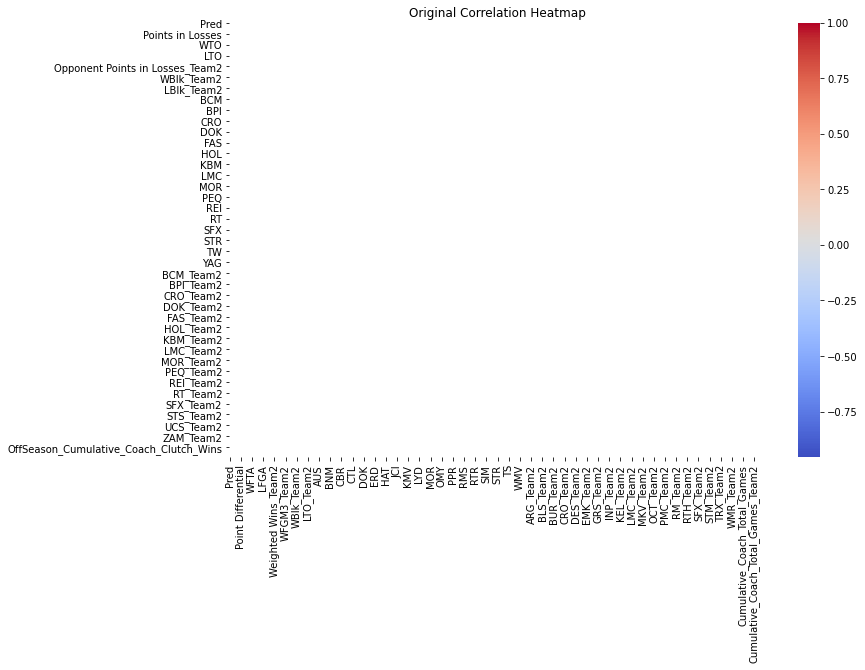

🔥 Removed Features Due to High Correlation:
{'BRZ', 'DC2_Team2', 'AWS', 'RWP', 'WMV', 'HER', 'MKV_Team2', 'KBM', 'STR_Team2', 'PIG', 'EMK_Team2', 'DCI_Team2', 'WLS', 'ADE_Team2', 'Cumulative_Coach_Total_Clutch_Games', 'CPR_Team2', 'RAG', 'RTB', 'ERD_Team2', 'MUZ_Team2', 'SP_Team2', 'ARG', 'KLK_Team2', 'KEL', 'RPI', 'PPR_Team2', 'DII', 'RME', 'KEL_Team2', 'WLK', 'SAP_Team2', 'TMR_Team2', 'YAG', 'ROH', 'TBD', 'CPA', 'SMN', 'TOL', 'BCM_Team2', 'REI_Team2', 'STH', 'DDB', 'EBP', 'COL_Team2', 'ROG', 'PIR', 'TPR_Team2', 'TRP', 'CRO_Team2', 'BOW_Team2', 'ESR_Team2', 'ECK', 'HKS_Team2', 'ERD', 'PTS', 'NOR_Team2', 'PGH_Team2', 'SAU_Team2', 'SRS_Team1', 'MAS', 'BOW', 'PIG_Team2', 'SAU', 'DII_Team2', 'BLS_Team2', 'NET', 'PEQ', 'SPW', 'KOS', 'WIL', 'SIM', 'PKL_Team2', 'STS', 'RPI_Team2', 'SCR_Team2', 'RM', 'RME_Team2', 'JCI', 'INC_Team2', 'DES', 'Cumulative_Coach_Clutch_Losses_Team2', 'JJK', 'STF_Team2', 'BRZ_Team2', 'LOG_Team2', 'KMV_Team2', 'DOK', 'INP_Team2', 'PPR', 'MGS', 'SGR', 'CRW_Team2', 'B

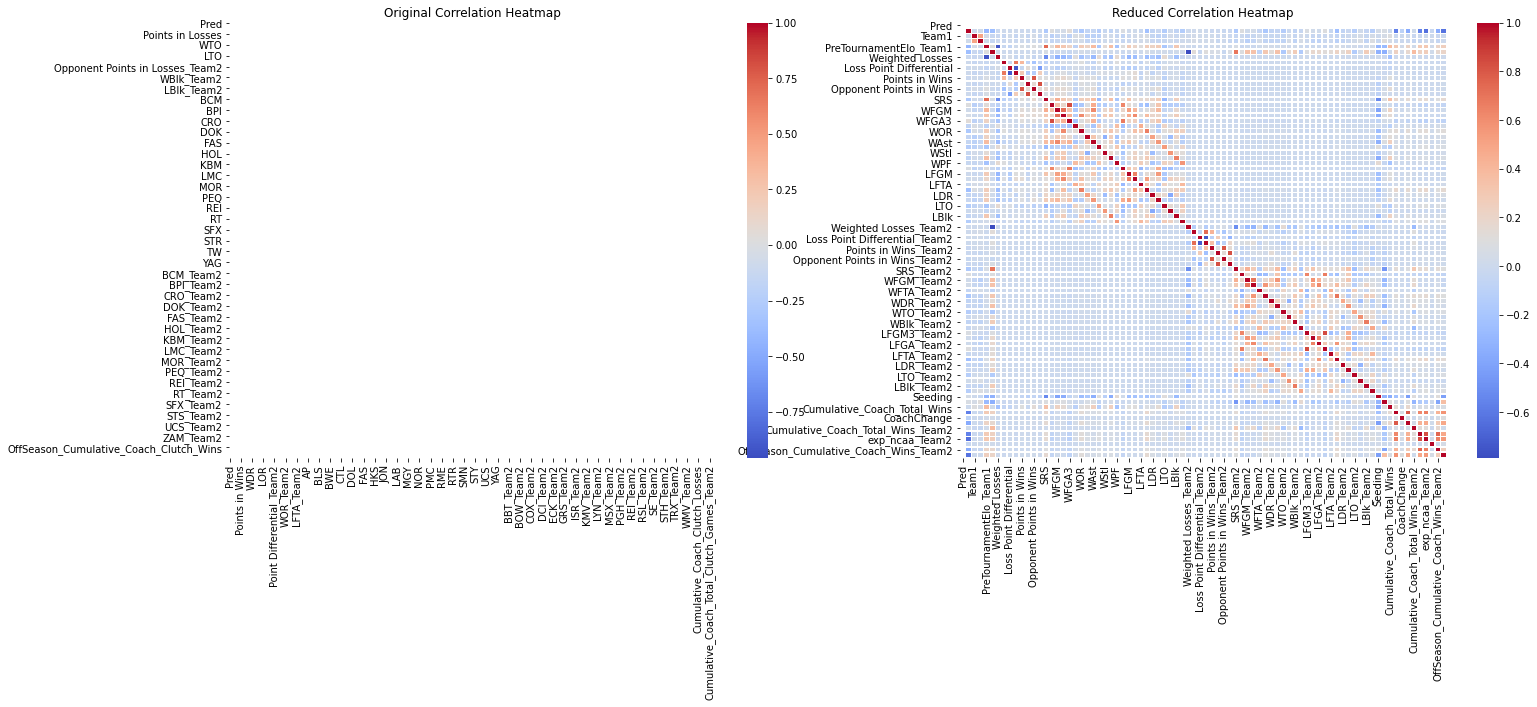

Original Features: 480, Reduced Features: 82


In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the original correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(male_train_test.corr(), annot=False, cmap="coolwarm", linewidths=0.5)
plt.title("Original Correlation Heatmap")
plt.show()

# Your code to identify and drop high-correlation features
corr_matrix = male_train_test.corr()
corr_threshold = 0.85
high_corr_features = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > corr_threshold:
            colname = corr_matrix.columns[i]
            high_corr_features.add(colname)

# Step 4: Drop highly correlated features
male_train_test_reduced = male_train_test.drop(columns=high_corr_features, errors='ignore')

# Display removed features
print("🔥 Removed Features Due to High Correlation:")
print(high_corr_features)

fig, axes = plt.subplots(1, 2, figsize=(24, 8))

# Original correlation heatmap
sns.heatmap(male_train_test.corr(), ax=axes[0], annot=False, cmap="coolwarm", linewidths=0.5)
axes[0].set_title("Original Correlation Heatmap")

# Reduced correlation heatmap
sns.heatmap(male_train_test_reduced.corr(), ax=axes[1], annot=False, cmap="coolwarm", linewidths=0.5)
axes[1].set_title("Reduced Correlation Heatmap")

plt.show()
# Check the new shape
print(f"Original Features: {male_train_test.shape[1]}, Reduced Features: {male_train_test_reduced.shape[1]}")


In [39]:
#male_train_super_reduced.to_csv(r"C:\Users\Admin\Desktop\Kaggle\March_Machine_Learning_Mania_2025\input\male_train_super_reduced.csv",index = False)

In [40]:
X = male_train_test.drop(['Pred', 'observe'],axis = 1)
y = male_train_test['observe']
X_train, X_test,y_train, y_test =  X[X['Season'] < 2025], X[X['Season'] == 2025], y[X['Season'] < 2025], y[X['Season'] == 2025]
X_train.columns = X_train.columns.str.replace(" ", "_")



In [41]:
print(X_train.shape)
print(X_test)

(2545, 478)
       Season  Team1  Team2  PreTournamentElo_Team1  PreTournamentElo_Team2  \
0        2025   1101   1102             1584.846850             1512.677055   
1        2025   1101   1103             1584.846850             1844.699878   
2        2025   1101   1104             1584.846850             1949.173483   
3        2025   1101   1105             1584.846850             1475.338249   
4        2025   1101   1106             1584.846850             1520.105999   
...       ...    ...    ...                     ...                     ...   
68617    2025   1477   1479             1430.131560             1571.668587   
68618    2025   1477   1480             1430.131560             1430.977148   
68619    2025   1478   1479             1469.745802             1571.668587   
68620    2025   1478   1480             1469.745802             1430.977148   
68621    2025   1479   1480             1571.668587             1430.977148   

       Weighted Wins  Weighted Losses  

In [42]:
import lightgbm as lgb
import pandas as pd
import numpy as np
from sklearn.metrics import brier_score_loss
# Convert data into LightGBM Dataset format
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Define LightGBM parameters
params = {
    'objective': 'binary',  # Use 'multiclass' for multiple categories
    'metric': 'brier',  # You can also use 'logloss', 'auc', etc.
    'boosting_type': 'gbdt',  # Gradient Boosting Decision Tree
    'learning_rate': 0.05,
    'num_leaves': 31,
    'max_depth': -1,
    'random_state': 42
}

# Train the model
model = lgb.train(params, train_data, valid_sets=[test_data], num_boost_round=500)
y_pred_prob = model.predict(X_test)  # Predict probabilities



[LightGBM] [Info] Number of positive: 1304, number of negative: 1241
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010530 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 80533
[LightGBM] [Info] Number of data points in the train set: 2545, number of used features: 476
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512377 -> initscore=0.049519
[LightGBM] [Info] Start training from score 0.049519


In [43]:
X_test['ID'] = (
    X_test['Season'].astype(str) + '_' +
    X_test['Team1'].astype(str) + '_' +
    X_test['Team2'].astype(str)
)

<ipython-input-43-fc884d238bc1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['ID'] = (


In [44]:
X_test['Pred'] = y_pred_prob

<ipython-input-44-06f0c38432f9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['Pred'] = y_pred_prob


In [45]:
submit = X_test.merge(men_teams, how = 'left', left_on = 'Team1', right_on = 'TeamID').drop(['TeamID'],axis = 1)
submit = submit.merge(men_teams, how = 'left', left_on = 'Team2', right_on = 'TeamID').drop(['TeamID'],axis = 1)

In [46]:
import matplotlib.pyplot as plt

# Get feature importance (using gain, which is the total gain of splits which use the feature)
importance = model.feature_importance(importance_type='gain')
feature_names = model.feature_name()

# Create a DataFrame to display feature importances
feature_imp = pd.DataFrame({'feature': feature_names, 'importance': importance})
feature_imp = feature_imp.sort_values(by='importance', ascending=False)

pd.set_option ('display.max_columns', None)
# Display the DataFrame
print(feature_imp)




                    feature   importance
3    PreTournamentElo_Team1  6502.765130
4    PreTournamentElo_Team2  5438.153953
456                 Seeding  4712.186604
457           Seeding_Team2  3208.352475
5             Weighted_Wins  2434.835158
..                      ...          ...
190                     PAC     0.000000
365               MCL_Team2     0.000000
240                     STS     0.000000
156                     KCX     0.000000
143                     HOL     0.000000

[478 rows x 2 columns]


In [47]:
print(f"Train Data: {X_train.shape}, Test Data: {X_test.shape}")
print(f"Train Season Range: {X_train['Season'].min()} to {X_train['Season'].max()}")
print(f"Test Season Range: {X_test['Season'].min()} to {X_test['Season'].max()}")

Train Data: (2545, 478), Test Data: (68622, 480)
Train Season Range: 1985 to 2024
Test Season Range: 2025 to 2025


In [48]:
import lightgbm as lgb
from sklearn.metrics import brier_score_loss

# ✅ Define the best parameters found earlier
params = {
    'objective': 'binary',  
    'metric': 'brier',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,  
    'num_leaves': 31,  
    'max_depth': -1,  
    'random_state': 42  
}

# ✅ Convert data into LightGBM Dataset format
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# ✅ Train the final model
final_model = lgb.train(params, train_data, valid_sets=[test_data], num_boost_round=500)

# ✅ Predict probabilities for the test set
y_pred_prob = final_model.predict(X_test)

# ✅ Compute the final Brier score
final_brier = brier_score_loss(y_test, y_pred_prob)
print(f"Final Test Brier Score: {final_brier}")


[LightGBM] [Info] Number of positive: 1304, number of negative: 1241
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016596 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 80533
[LightGBM] [Info] Number of data points in the train set: 2545, number of used features: 476


ValueError: pandas dtypes must be int, float or bool.
Fields with bad pandas dtypes: ID: object

In [49]:
submit.columns

Index(['Season', 'Team1', 'Team2', 'PreTournamentElo_Team1',
       'PreTournamentElo_Team2', 'Weighted Wins', 'Weighted Losses',
       'Win Point Differential', 'Loss Point Differential',
       'Point Differential',
       ...
       'OffSeason_Cumulative_Coach_Wins_Team2',
       'OffSeason_Cumulative_Coach_Clutch_Wins_Team2', 'ID', 'Pred',
       'TeamName_x', 'FirstD1Season_x', 'LastD1Season_x', 'TeamName_y',
       'FirstD1Season_y', 'LastD1Season_y'],
      dtype='object', length=486)

In [50]:
team_x = ['Auburn', 'Arizona', 'Michigan St', 'Alabama', 'Florida', 'Houston', 'Arkansas', 'Kentucky']
team_y = ['Michigan', 'Duke', 'Mississippi', 'BYU', 'Maryland', 'Purdue', 'Texas Tech', 'Tennessee']

matchups = pd.DataFrame({'TeamName_x': team_x, 'TeamName_y': team_y})

# Merge to filter matching rows
matched_rows = submit.merge(matchups, on=['TeamName_x', 'TeamName_y'], how='inner')
matched_rows[['TeamName_x', 'TeamName_y', 'Pred']]

,TeamName_x,TeamName_y,Pred
0,Alabama,BYU,0.013269
1,Arizona,Duke,0.153250
2,Arkansas,Texas Tech,0.478849
3,Auburn,Michigan,0.406461
4,Florida,Maryland,0.577198
5,Houston,Purdue,0.982606
6,Kentucky,Tennessee,0.250631
7,Michigan St,Mississippi,0.040537


In [51]:
matched_rows.to_csv(r"C:\Users\Admin\Desktop\Kaggle\March_Machine_Learning_Mania_2025\input\male_submit.csv",index = False)